In [31]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import Sequential
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
tf.__version__

'2.8.2'

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# Avoid out of Memory errors by limiting GPU use
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [37]:
IMAGE_SIZE = [224, 224]
#passing the file paths into a variable name
train = "/content/drive/MyDrive/Data/Train"
test = "/content/drive/MyDrive/Data/Test"

In [38]:
#to check how many classes exist in the training set
folder = glob( "/content/drive/MyDrive/Data/Train")
len(folder)

1

In [39]:
# Use the Image Data Generator to import the images from the dataset and normalise them
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255)

test_datagen = ImageDataGenerator(rescale = 1/255)


training = train_datagen.flow_from_directory("/content/drive/MyDrive/Data/Train",
                                                 batch_size = 200,
                                                  class_mode = 'categorical',
                                                   shuffle = True)

test_set = test_datagen.flow_from_directory("/content/drive/MyDrive/Data/Test",
                                            target_size = (224, 224),
                                            batch_size = 200,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 1192 images belonging to 100 classes.
Found 1182 images belonging to 100 classes.


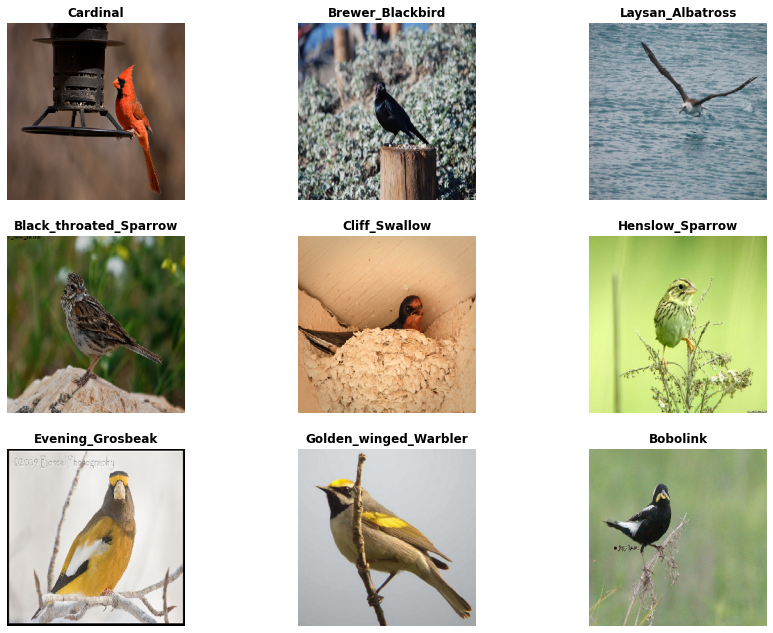

In [40]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for row in range(0, 3):
    for col in range(0, 3):
        image, label = training.next()
        label_id = list(label[0]).index(1)
        label_str = list(training.class_indices.keys())[list(training.class_indices.values()).index(label_id)]
        ax = fig.add_subplot(gs[row, col])
        ax.axis('off');
        ax.set_title(label_str, fontdict={"fontweight": 700})
        ax.imshow(image[0]);


In [41]:



#data augmentation
#This would only be applied to my training data. looking at the data rotated within 40 degrees would give more data without a change to the mostly vertically sitting birds. 
Augment_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, # Rotate the images randomly by 40 degrees
    width_shift_range=0.4, # Shift the image horizontally by 20%
    height_shift_range=0.4, # Shift the image veritcally by 20%
    zoom_range=0.4, # Zoom in on image by 20% 
    horizontal_flip=True, # Flip image horizontally 
    fill_mode='nearest') 
Augmentation = Augment_datagen.flow_from_directory("/content/drive/MyDrive/Data/Train", target_size=(224,224))


print('data groups:', len(Augmentation)) #Will be used to determine steps_per_epoch in my models.

Found 1192 images belonging to 100 classes.
data groups: 38


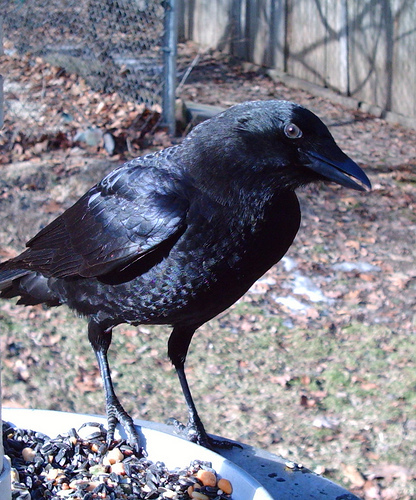

In [42]:
import matplotlib.pyplot as plt
import os
import PIL
import pathlib

data_dir = pathlib.Path(train)
data_dir

tulips = list(data_dir.glob('American_Crow/*'))
PIL.Image.open(str(tulips[2]))



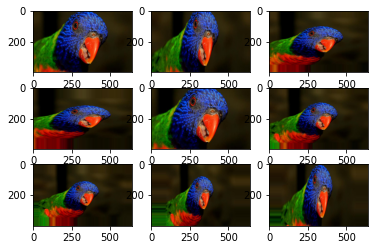

In [43]:

# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img("/content/drive/MyDrive/Data/bird.jpg")
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=[-200,200])
datagen = ImageDataGenerator(horizontal_flip=True)
datagen = ImageDataGenerator(zoom_range=0.5)
datagen1 = ImageDataGenerator(height_shift_range=1)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

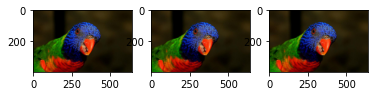

In [44]:

# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img("/content/drive/MyDrive/Data/bird.jpg")
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen1 = ImageDataGenerator(width_shift_range=1)
# prepare iterator
it = datagen1.flow(samples, batch_size=1)
# generate samples and plot
for i in range(3):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [45]:
model4 = Sequential()

model4.add(Conv2D(16, (3, 3), padding='same',input_shape= (224, 224, 3))) #224X224
model4.add(Activation('relu'))
model4.add(MaxPool2D(pool_size=(2, 2)))
model4.add(BatchNormalization())

model4.add(Conv2D(32, (3, 3))) #222x222
model4.add(Activation('relu'))
model4.add(MaxPool2D(pool_size=(2, 2))) #111x111
model4.add(BatchNormalization())

model4.add(Conv2D(64, (3, 3))) #222x222
model4.add(Activation('relu'))
model4.add(MaxPool2D(pool_size=(2, 2))) #111x111
model4.add(BatchNormalization())
model4.add(Dropout(0.35))

model4.add(Conv2D(128, (3, 3))) #222x222
model4.add(Activation('relu'))
model4.add(MaxPool2D(pool_size=(2, 2))) #111x111
model4.add(BatchNormalization())
model4.add(Dropout(0.35))
#model4.add(Dropout(0.35)) #Doesn't appear to be working in the model summary.

model4.add(Conv2D(256, (3, 3), padding='same')) #54x54
model4.add(Activation('relu'))
#model4.add(MaxPool2D(pool_size=(2, 2)))
model4.add(BatchNormalization())

model4.add(Flatten()) 
model4.add(Dropout(0.5)) 
model4.add(Dense(512)) 
model4.add(Activation('relu'))
model4.add(BatchNormalization())

model4.add(Dense(100)) #Updated for number of classes
model4.add(Activation('softmax'))


In [46]:
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 activation (Activation)     (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 activation_1 (Activation)   (None, 110, 110, 32)      0

In [47]:
model4.compile(optimizer = tf.keras.optimizers.SGD(lr=0.001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
# Fit the model
history3 = model4.fit(Augmentation, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(Augmentation),
                          validation_data=test_set,
                          validation_steps=0.25*len(test_set))


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/5
38/38 [==============================] - 259s 7s/step - loss: 5.3153 - accuracy: 0.0109 - val_loss: 4.6262 - val_accuracy: 0.0125
Epoch 2/5
38/38 [==============================] - 185s 5s/step - loss: 5.3051 - accuracy: 0.0159 - val_loss: 4.6890 - val_accuracy: 0.0175
Epoch 3/5
38/38 [==============================] - 142s 4s/step - loss: 5.3219 - accuracy: 0.0134 - val_loss: 4.7159 - val_accuracy: 0.0150
Epoch 4/5
38/38 [==============================] - 121s 3s/step - loss: 5.1373 - accuracy: 0.0151 - val_loss: 4.7582 - val_accuracy: 0.0225
Epoch 5/5
38/38 [==============================] - 119s 3s/step - loss: 5.1952 - accuracy: 0.0151 - val_loss: 4.8486 - val_accuracy: 0.0025


Text(0.5, 0, 'epoch')

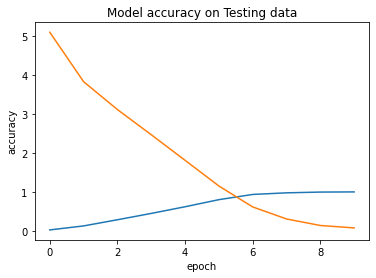

In [53]:

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['loss'])
plt.title('Model accuracy on Testing data')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [51]:
model4.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
# Fit the model
history3 = model4.fit(test_set, # use augmented data
                          epochs=10 ,
                          steps_per_epoch=len(test_set),
                          validation_data=test_set,
                          validation_steps=0.25*len(test_set))



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
6/6 [==============================] - 100s 16s/step - loss: 5.0916 - accuracy: 0.0228 - val_loss: 5.6772 - val_accuracy: 0.0875
Epoch 2/10
6/6 [==============================] - 93s 15s/step - loss: 3.8241 - accuracy: 0.1252 - val_loss: 5.1083 - val_accuracy: 0.1225
Epoch 3/10
6/6 [==============================] - 94s 15s/step - loss: 3.1089 - accuracy: 0.2834 - val_loss: 3.5600 - val_accuracy: 0.2000
Epoch 4/10
6/6 [==============================] - 96s 16s/step - loss: 2.4639 - accuracy: 0.4459 - val_loss: 2.5218 - val_accuracy: 0.3700
Epoch 5/10
6/6 [==============================] - 100s 17s/step - loss: 1.8079 - accuracy: 0.6168 - val_loss: 2.1673 - val_accuracy: 0.4875
Epoch 6/10
6/6 [==============================] - 94s 16s/step - loss: 1.1492 - accuracy: 0.7986 - val_loss: 1.6593 - val_accuracy: 0.7175
Epoch 7/10
6/6 [==============================] - 91s 15s/step - loss: 0.6121 - accuracy: 0.9323 - val_loss: 1.5771 - val_accuracy: 0.8225
Epoch 8/10
6/6 [=========

In [2]:

#  